# Comparing Real and Synthetic Skin Lesion Images

This notebook compares real and synthetic images from the HAM10000 dataset using dimensionality reduction techniques:
- t-SNE (t-Distributed Stochastic Neighbor Embedding)
- PCA (Principal Component Analysis)
- LDA (Linear Discriminant Analysis)

We focus on three specific classes:
- AKIEC: Actinic Keratoses and Intraepithelial Carcinoma
- DF: Dermatofibroma
- VASC: Vascular Lesions

## 1. Setup and Import Libraries

In [13]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import random
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)

## 2. Define Paths and Load Metadata

In [14]:
# Define paths using relative paths
import os
from pathlib import Path

# Define paths similar to your working code in other notebooks
DATA_ROOT = Path('../data')  # Assuming notebook is one level below data
RAW_DATA_PATH = DATA_ROOT / 'raw'
PROCESSED_PATH = DATA_ROOT / 'processed' / 'images'
PROCESSED_SD_PATH = DATA_ROOT / 'processed_sd'
SYNTHETIC_PATH = DATA_ROOT / 'synthetic'  # Path to synthetic images

# Paths for specific files
METADATA_PATH = RAW_DATA_PATH / 'HAM10000_metadata.csv'
REAL_IMAGES_PATH = PROCESSED_SD_PATH / 'images'  # Using 512x512 images to match synthetic ones

# Print current working directory for debugging
print(f"Current working directory: {os.getcwd()}")
print(f"Data root path: {DATA_ROOT.absolute()}")

# Verify paths exist
print(f"Metadata file exists: {METADATA_PATH.exists()}")
print(f"Processed images path exists: {PROCESSED_PATH.exists()}")
print(f"Processed SD images path exists: {REAL_IMAGES_PATH.exists()}")
print(f"Synthetic images path exists: {SYNTHETIC_PATH.exists()}")

# If metadata file isn't found, try alternative path based on your working code
if not METADATA_PATH.exists():
    csv_path = os.path.join('../data/raw/', 'HAM10000_metadata.csv')
    print(f"Trying alternative path: {csv_path}")
    print(f"Alternative path exists: {os.path.exists(csv_path)}")
    if os.path.exists(csv_path):
        METADATA_PATH = Path(csv_path)
        print(f"Updated metadata path: {METADATA_PATH}")

Current working directory: /Users/jaypinion/Dev/msc-ai/mlp/mlp-cw4/notebooks
Data root path: /Users/jaypinion/Dev/msc-ai/mlp/mlp-cw4/notebooks/../data
Metadata file exists: True
Processed images path exists: True
Processed SD images path exists: True
Synthetic images path exists: True


In [5]:
# Load HAM10000 metadata
metadata = pd.read_csv(METADATA_PATH)
print(f"Total images in metadata: {len(metadata)}")

# Filter for the classes we're interested in: AKIEC, DF, and VASC
classes_of_interest = ['akiec', 'df', 'vasc']
filtered_metadata = metadata[metadata['dx'].isin(classes_of_interest)]
print(f"Images in selected classes: {len(filtered_metadata)}")

# Display class distribution
class_distribution = filtered_metadata['dx'].value_counts()
print("\nClass distribution:")
print(class_distribution)

Total images in metadata: 10015
Images in selected classes: 584

Class distribution:
dx
akiec    327
vasc     142
df       115
Name: count, dtype: int64


## 3. Create Train/Test Split

We'll implement the same train/test split strategy as in the provided code to ensure consistency.

In [15]:
def create_train_test_split(metadata, train_ratio=0.8, random_seed=42):
    """
    Create a train/test split of the HAM10000 dataset.
    Splits are stratified by lesion type.

    Args:
        metadata: DataFrame containing HAM10000 metadata
        train_ratio: Ratio of images to use for training (default 0.8)
        random_seed: Random seed for reproducibility (default 42)
    
    Returns:
        train_df, test_df: DataFrames containing train and test splits
    """
    # Set random seed
    random.seed(random_seed)
    np.random.seed(random_seed)
    
    # Initialise dataframes for train and test splits
    train_df = pd.DataFrame(columns=metadata.columns)
    test_df = pd.DataFrame(columns=metadata.columns)
    
    # Get unique lesion types
    lesion_types = metadata["dx"].unique()
    
    # Track counts
    counts = {}
    
    # Process each lesion type
    for lesion_type in lesion_types:
        # Filter metadata for this lesion type
        lesion_metadata = metadata[metadata["dx"] == lesion_type].copy()
        
        # Shuffle the metadata
        lesion_metadata = lesion_metadata.sample(frac=1, random_state=random_seed)
        
        # Get train/test counts
        total_count = len(lesion_metadata)
        train_count = int(total_count * train_ratio)
        test_count = total_count - train_count
        
        # Store counts
        counts[lesion_type] = {
            "total": total_count,
            "train": train_count,
            "test": test_count,
        }
        
        # Create train/test splits
        train_metadata = lesion_metadata.iloc[:train_count]
        test_metadata = lesion_metadata.iloc[train_count:]
        
        # Add to train/test dataframes
        train_df = pd.concat([train_df, train_metadata])
        test_df = pd.concat([test_df, test_metadata])
    
    # Print summary of counts by class
    print("Class distribution in splits:")
    for lesion_type, count_data in counts.items():
        print(f"  {lesion_type}: {count_data['train']} train, {count_data['test']} test")
    
    return train_df, test_df

# Create train/test split
train_df, test_df = create_train_test_split(filtered_metadata)

Class distribution in splits:
  df: 92 train, 23 test
  vasc: 113 train, 29 test
  akiec: 261 train, 66 test


## 4. Load Synthetic Images

We'll create a function to scan the synthetic image directories and build metadata for these images.

In [16]:
def load_synthetic_metadata(synthetic_dir, classes_of_interest):
    """
    Create metadata for synthetic images.
    
    Args:
        synthetic_dir: Directory containing synthetic images (with class subdirectories)
        classes_of_interest: List of classes to include
        
    Returns:
        DataFrame with synthetic image metadata
    """
    synthetic_data = []
    
    for class_name in classes_of_interest:
        class_dir = Path(synthetic_dir) / class_name
        
        if not class_dir.exists():
            print(f"Warning: {class_dir} does not exist.")
            continue
            
        # Look for both .png and .jpg files
        for ext in ['.png', '.jpg']:
            for img_path in class_dir.glob(f'*{ext}'):
                img_id = img_path.stem
                
                synthetic_data.append({
                    'image_id': img_id,
                    'dx': class_name,
                    'is_synthetic': True,
                    'file_path': str(img_path)
                })
    
    synthetic_df = pd.DataFrame(synthetic_data)
    
    if len(synthetic_df) > 0:
        # Display class distribution
        class_distribution = synthetic_df['dx'].value_counts()
        print(f"Found {len(synthetic_df)} synthetic images")
        print("\nSynthetic class distribution:")
        print(class_distribution)
    else:
        print("No synthetic images found.")
        
    return synthetic_df

# Load synthetic image metadata
synthetic_df = load_synthetic_metadata(SYNTHETIC_PATH, classes_of_interest)

Found 1200 synthetic images

Synthetic class distribution:
dx
df       450
vasc     450
akiec    300
Name: count, dtype: int64


## 5. Create Custom Dataset Classes for Loading Images

In [17]:
class SkinLesionDataset(Dataset):
    """
    Dataset for skin lesion images (HAM10000)
    """
    def __init__(self, metadata, image_dir, transform=None, is_synthetic=False):
        """
        Args:
            metadata: DataFrame containing image metadata
            image_dir: Directory containing the images
            transform: Optional transform to be applied on a sample
            is_synthetic: Whether this dataset contains synthetic images
        """
        self.metadata = metadata
        self.image_dir = Path(image_dir)
        self.transform = transform
        self.is_synthetic = is_synthetic
        
    def __len__(self):
        return len(self.metadata)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        row = self.metadata.iloc[idx]
        img_id = row['image_id']
        lesion_type = row['dx']
        
        # For real images, check for both .jpg and .png extensions
        if not self.is_synthetic:
            img_path = None
            for ext in ['.jpg', '.png']:
                potential_path = self.image_dir / f"{img_id}{ext}"
                if potential_path.exists():
                    img_path = potential_path
                    break
            
            if img_path is None:
                raise FileNotFoundError(f"Image {img_id} not found in {self.image_dir}")
        else:
            # For synthetic images, use the path from metadata
            if 'file_path' in row:
                img_path = row['file_path']
            else:
                # Fallback: construct path based on class
                img_path = self.image_dir / lesion_type / f"{img_id}.png"  
                if not os.path.exists(img_path):
                    img_path = self.image_dir / lesion_type / f"{img_id}.jpg"
                    
        # Load image
        image = Image.open(img_path).convert('RGB')
        
        # Apply transformations
        if self.transform:
            image = self.transform(image)
            
        return {
            'image': image,
            'label': lesion_type,
            'image_id': img_id,
            'is_synthetic': self.is_synthetic
        }

## 6. Define Image Transformations and Create Datasets

In [18]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to fit the pre-trained model
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

# Create datasets
try:
    train_dataset = SkinLesionDataset(train_df, REAL_IMAGES_PATH, transform=transform)
    print(f"Created training dataset with {len(train_dataset)} images")
    
    if len(synthetic_df) > 0:
        synthetic_dataset = SkinLesionDataset(synthetic_df, SYNTHETIC_PATH, transform=transform, is_synthetic=True)
        print(f"Created synthetic dataset with {len(synthetic_dataset)} images")
    else:
        print("No synthetic dataset created (no images found)")
except Exception as e:
    print(f"Error creating datasets: {e}")

Created training dataset with 466 images
Created synthetic dataset with 1200 images


## 7. Feature Extraction using Pre-trained Model

We'll use a pre-trained ResNet-50 model to extract features from our images.

In [20]:
# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

if 'synthetic_dataset' in locals():
    synthetic_loader = DataLoader(synthetic_dataset, batch_size=batch_size, shuffle=False)
else:
    synthetic_loader = None

# Function to extract features using a pre-trained model
def extract_features(dataloader, model, device):
    """
    Extract features from images using a pre-trained model.
    
    Args:
        dataloader: DataLoader containing the images
        model: Pre-trained model to use for feature extraction
        device: Device to run the model on
        
    Returns:
        features: Extracted features
        labels: Corresponding labels
        image_ids: Corresponding image IDs
        is_synthetic: Whether each image is synthetic
    """
    features = []
    labels = []
    image_ids = []
    is_synthetic_list = []
    
    model.eval()
    with torch.no_grad():
        # Use regular tqdm instead of the notebook version
        for batch in tqdm(dataloader, desc="Extracting features"):
            images = batch['image'].to(device)
            batch_features = model(images)
            
            features.append(batch_features.cpu().numpy())
            labels.extend(batch['label'])
            image_ids.extend(batch['image_id'])
            is_synthetic_list.extend(batch['is_synthetic'])
    
    features = np.vstack(features)
    
    return features, labels, image_ids, is_synthetic_list

# Load a pre-trained model and modify it for feature extraction
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Use ResNet-50 with the final FC layer removed
model = models.resnet50(pretrained=True)
model = torch.nn.Sequential(*(list(model.children())[:-1]))  # Remove the final FC layer
model = model.to(device)

Using device: cpu


In [21]:
# Extract features
print("Extracting features from training images...")
train_features, train_labels, train_image_ids, train_is_synthetic = extract_features(train_loader, model, device)

# Reshape features (remove the extra dimension from global average pooling)
train_features = train_features.reshape(train_features.shape[0], -1)
print(f"Training features shape: {train_features.shape}")

if synthetic_loader is not None:
    print("\nExtracting features from synthetic images...")
    synthetic_features, synthetic_labels, synthetic_image_ids, synthetic_is_synthetic = extract_features(synthetic_loader, model, device)
    synthetic_features = synthetic_features.reshape(synthetic_features.shape[0], -1)
    print(f"Synthetic features shape: {synthetic_features.shape}")
else:
    print("\nNo synthetic images to process.")
    synthetic_features, synthetic_labels = None, None

Extracting features from training images...


Extracting features: 100%|██████████| 15/15 [00:53<00:00,  3.53s/it]


Training features shape: (466, 2048)

Extracting features from synthetic images...


Extracting features: 100%|██████████| 38/38 [02:22<00:00,  3.75s/it]

Synthetic features shape: (1200, 2048)


## 8. Dimensionality Reduction and Visualization

Now we'll implement the dimensionality reduction techniques: t-SNE, PCA, and LDA.

In [68]:
def apply_dimensionality_reduction(real_features, real_labels, synthetic_features=None, synthetic_labels=None, method='tsne'):
    """
    Apply dimensionality reduction to features.
    
    Args:
        real_features: Features from real images
        real_labels: Labels for real images
        synthetic_features: Features from synthetic images (optional)
        synthetic_labels: Labels for synthetic images (optional)
        method: Dimensionality reduction method ('tsne', 'pca', or 'lda')
        
    Returns:
        Dictionary containing the reduced features
    """
    # Convert labels to numeric if they're not already
    if synthetic_labels is not None:
        unique_labels = np.unique(np.concatenate([real_labels, synthetic_labels]))
    else:
        unique_labels = np.unique(real_labels)
        
    label_to_id = {label: i for i, label in enumerate(unique_labels)}
    
    real_numeric_labels = np.array([label_to_id[label] for label in real_labels])
    
    if synthetic_features is not None and synthetic_labels is not None:
        synthetic_numeric_labels = np.array([label_to_id[label] for label in synthetic_labels])
        
        # Combine features and labels
        combined_features = np.vstack([real_features, synthetic_features])
        combined_labels = np.concatenate([real_numeric_labels, synthetic_numeric_labels])
        
        # Create a flag to identify real vs synthetic
        is_synthetic = np.concatenate([np.zeros(len(real_features)), np.ones(len(synthetic_features))])
    else:
        combined_features = real_features
        combined_labels = real_numeric_labels
        is_synthetic = None
    
    # Apply dimensionality reduction
    if method == 'tsne':
        print(f"Applying t-SNE to {len(combined_features)} samples...")
        reducer = TSNE(n_components=2, random_state=random_seed)
        reduced_features = reducer.fit_transform(combined_features)
    elif method == 'pca':
        print(f"Applying PCA to {len(combined_features)} samples...")
        reducer = PCA(n_components=2, random_state=random_seed)
        reduced_features = reducer.fit_transform(combined_features)
    elif method == 'lda':
        print(f"Applying LDA to {len(combined_features)} samples...")
        n_classes = len(np.unique(combined_labels))
        
        # Check if we have enough classes for LDA
        if n_classes <= 1:
            print(f"Warning: Only {n_classes} class found. LDA requires at least 2 classes.")
            print("Falling back to PCA for dimensionality reduction")
            reducer = PCA(n_components=2, random_state=random_seed)
            reduced_features = reducer.fit_transform(combined_features)
        else:
            # Fix: Make sure n_components doesn't exceed the limit and is at least 1
            n_components = max(1, min(2, n_classes - 1))
            reducer = LDA(n_components=n_components)
            
            # Apply LDA
            lda_result = reducer.fit_transform(combined_features, combined_labels)
            
            # If we only have 1 component, add a second dummy dimension
            if n_components == 1:
                # Add a small amount of noise as second dimension
                second_dim = np.random.normal(0, 0.01, size=len(lda_result))
                reduced_features = np.column_stack((lda_result, second_dim))
                print("Note: Added dummy dimension for visualisation since LDA only produced 1 component")
            else:
                reduced_features = lda_result
    else:
        raise ValueError(f"Unknown method: {method}")
    
    # Split back into real and synthetic
    if is_synthetic is not None:
        real_indices = np.where(is_synthetic == 0)[0]
        synthetic_indices = np.where(is_synthetic == 1)[0]
        
        result = {
            'real': {
                'features': reduced_features[real_indices],
                'labels': real_labels
            },
            'synthetic': {
                'features': reduced_features[synthetic_indices],
                'labels': synthetic_labels
            },
            'label_to_id': label_to_id
        }
    else:
        result = {
            'real': {
                'features': reduced_features,
                'labels': real_labels
            },
            'label_to_id': label_to_id
        }
    
    return result

In [69]:
def plot_dimensionality_reduction(result, method='tsne', title=None, figsize=(10, 6)):
    """
    Plot the results of dimensionality reduction.
    
    Args:
        result: Dictionary containing the reduced features
        method: Dimensionality reduction method ('tsne', 'pca', or 'lda')
        title: Plot title
        figsize: Figure size
    """
    plt.figure(figsize=figsize)
    
    # Define colours for classes
    classes = list(result['label_to_id'].keys())
    num_classes = len(classes)
    class_colors = plt.cm.tab10(np.linspace(0, 1, num_classes))
    
    # Create a mapping of class name to colour
    class_to_color = {cls: class_colors[i] for i, cls in enumerate(classes)}
    
    # Plot real data
    for label in classes:
        mask = np.array(result['real']['labels']) == label
        plt.scatter(
            result['real']['features'][mask, 0],
            result['real']['features'][mask, 1],
            color=class_to_color[label],
            label=f'Real {label}',
            alpha=0.7,
            marker='o'
        )
    
    # Plot synthetic data if available
    if 'synthetic' in result:
        for label in classes:
            mask = np.array(result['synthetic']['labels']) == label
            plt.scatter(
                result['synthetic']['features'][mask, 0],
                result['synthetic']['features'][mask, 1],
                color=class_to_color[label],
                label=f'Synthetic {label}',
                alpha=0.7,
                marker='x'
            )
    
    # Add legend and title
    plt.legend()
    if title:
        plt.title(title)
    else:
        plt.title(f'{method.upper()} Visualisation')
    
    plt.tight_layout()
    plt.show()

In [70]:
def plot_two_classes_comparison(real_features, real_labels, method='lda', classes=None, figsize=(10, 6)):
    """
    Plot comparison between two classes of real images.
    
    Args:
        real_features: Features from real images
        real_labels: Labels for real images
        method: Dimensionality reduction method ('tsne', 'pca', or 'lda')
        classes: Two classes to compare
        figsize: Figure size
    """
    if classes is None or len(classes) != 2:
        raise ValueError("Must specify exactly two classes to compare")
    
    # Filter features and labels for the two classes
    mask = np.isin(real_labels, classes)
    filtered_features = real_features[mask]
    filtered_labels = np.array(real_labels)[mask]
    
    # Make sure we have enough samples for each class
    for cls in classes:
        cls_count = sum(filtered_labels == cls)
        if cls_count < 2:
            print(f"Warning: Only {cls_count} samples for class {cls}. Need at least 2 samples.")
            # Add some duplicate samples to make LDA work
            if cls_count == 1:
                idx = np.where(filtered_labels == cls)[0][0]
                sample = filtered_features[idx].reshape(1, -1)
                filtered_features = np.vstack([filtered_features, sample])
                filtered_labels = np.append(filtered_labels, cls)
    
    print(f"Comparing classes {classes[0]} and {classes[1]} using {method.upper()}")
    print(f"Number of samples: {len(filtered_features)}")
    
    # Apply dimensionality reduction
    result = apply_dimensionality_reduction(filtered_features, filtered_labels, method=method)
    
    # Plot
    plot_dimensionality_reduction(
        result, 
        method=method, 
        title=f'{method.upper()} Visualisation: {classes[0]} vs {classes[1]}',
        figsize=figsize
    )

In [77]:
def plot_real_vs_synthetic_comparison(real_features, real_labels, synthetic_features, synthetic_labels, 
                                     method='lda', class_name=None, figsize=(10, 6)):
    """
    Plot comparison between real and synthetic images for a specific class.
    """
    if class_name is None:
        raise ValueError("Must specify a class to compare")
    
    # Filter real features and labels for the class
    real_mask = np.array(real_labels) == class_name
    filtered_real_features = real_features[real_mask]
    filtered_real_labels = np.array(real_labels)[real_mask]
    
    # Filter synthetic features and labels for the class
    synthetic_mask = np.array(synthetic_labels) == class_name
    filtered_synthetic_features = synthetic_features[synthetic_mask]
    filtered_synthetic_labels = np.array(synthetic_labels)[synthetic_mask]
    
    print(f"Comparing real vs synthetic for class {class_name} using {method.upper()}")
    print(f"Number of real samples: {len(filtered_real_features)}")
    print(f"Number of synthetic samples: {len(filtered_synthetic_features)}")
    
    if len(filtered_real_features) == 0 or len(filtered_synthetic_features) == 0:
        print(f"Warning: Not enough samples to compare class {class_name}.")
        plt.figure(figsize=figsize)
        plt.title(f"No data for {class_name}")
        plt.text(0.5, 0.5, "Insufficient samples for comparison", 
                 horizontalalignment='center', verticalalignment='center',
                 transform=plt.gca().transAxes)
        plt.tight_layout()
        plt.show()
        return
    
    # For LDA, we need to differentiate between real and synthetic samples
    # by creating a new class for each
    real_type = 'Real'
    synth_type = 'Synthetic'
    
    # Use dataset type as the label instead of the class name
    temp_real_labels = np.array([real_type] * len(filtered_real_labels))
    temp_synthetic_labels = np.array([synth_type] * len(filtered_synthetic_labels))
    
    # Apply dimensionality reduction
    try:
        combined_features = np.vstack([filtered_real_features, filtered_synthetic_features])
        combined_labels = np.concatenate([temp_real_labels, temp_synthetic_labels])
        
        # For LDA we need different labels to separate the classes
        if method == 'lda':
            print("Using LDA to compare real vs synthetic (treating as 2 classes)")
            reducer = LDA(n_components=1)  # Just need 1 component for 2 classes
            reduced = reducer.fit_transform(combined_features, combined_labels)
            
            # Add a second dimension for visualization
            second_dim = np.random.normal(0, 0.01, size=len(reduced))
            reduced_features = np.column_stack((reduced, second_dim))
        elif method == 'pca':
            reducer = PCA(n_components=2)
            reduced_features = reducer.fit_transform(combined_features)
        elif method == 'tsne':
            reducer = TSNE(n_components=2, random_state=42)
            reduced_features = reducer.fit_transform(combined_features)
        
        # Normalize each dimension to [0,1] range to match the paper
        for col in range(reduced_features.shape[1]):
            min_val = np.min(reduced_features[:, col])
            max_val = np.max(reduced_features[:, col])
            range_val = max_val - min_val
            if range_val > 0:  # Avoid division by zero
                reduced_features[:, col] = (reduced_features[:, col] - min_val) / range_val
        
        # Split back to real and synthetic
        real_indices = list(range(len(filtered_real_features)))
        synthetic_indices = list(range(len(filtered_real_features), len(combined_features)))
        
        real_reduced = reduced_features[real_indices]
        synth_reduced = reduced_features[synthetic_indices]
        
        # Create the plot manually instead of using previous functions
        plt.figure(figsize=figsize)
        
        # Plot real data
        plt.scatter(
            real_reduced[:, 0],
            real_reduced[:, 1],
            color='blue',
            label=f'Real {class_name}',
            alpha=0.7,
            marker='o'
        )
        
        # Plot synthetic data
        plt.scatter(
            synth_reduced[:, 0],
            synth_reduced[:, 1],
            color='orange',
            label=f'Synthetic {class_name}',
            alpha=0.7,
            marker='x'
        )
        
        plt.title(f'{method.upper()} Visualisation: Real vs Synthetic {class_name}')
        plt.xlabel('Dimension 1')
        plt.ylabel('Dimension 2')
        plt.xlim(0, 1)  # Set x-axis to 0-1 range
        plt.ylim(0, 1)  # Set y-axis to 0-1 range
        plt.legend()
        plt.tight_layout()
        plt.savefig(f'{class_name}_{method}_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    except Exception as e:
        print(f"Error in dimensionality reduction: {e}")
        plt.figure(figsize=figsize)
        plt.title(f"Error processing {class_name}")
        plt.text(0.5, 0.5, str(e), 
                 horizontalalignment='center', verticalalignment='center',
                 transform=plt.gca().transAxes)
        plt.tight_layout()
        plt.show()

In [72]:
def create_class_comparison_table(real_features, real_labels, class_pairs, methods=['tsne', 'pca', 'lda'], figsize=(15, 12)):
    """
    Create a table of plots comparing pairs of classes, similar to Table IV in the paper.
    
    Args:
        real_features: Features from real images
        real_labels: Labels for real images
        class_pairs: Pairs of classes to compare
        methods: Dimensionality reduction methods to use
        figsize: Overall figure size
    """
    n_pairs = len(class_pairs)
    n_methods = len(methods)
    
    fig, axes = plt.subplots(n_pairs, n_methods, figsize=figsize)
    
    if n_pairs == 1 and n_methods == 1:
        axes = np.array([[axes]])  # Handle single subplot case
    elif n_pairs == 1:
        axes = axes.reshape(1, -1)
    elif n_methods == 1:
        axes = axes.reshape(-1, 1)
    
    for i, (class1, class2) in enumerate(class_pairs):
        print(f"Processing comparison {i+1}/{n_pairs}: {class1} vs {class2}")
        
        # Filter features and labels for the two classes
        mask = np.isin(real_labels, [class1, class2])
        filtered_features = real_features[mask]
        filtered_labels = np.array(real_labels)[mask]
        
        for j, method in enumerate(methods):
            print(f"  Applying {method.upper()}...")
            
            # Apply dimensionality reduction
            result = apply_dimensionality_reduction(filtered_features, filtered_labels, method=method)
            
            # Plot on the corresponding subplot
            ax = axes[i, j]
            
            # Define colours for classes
            class_colors = ['red', 'blue']
            
            # Plot data for class1
            mask1 = np.array(result['real']['labels']) == class1
            ax.scatter(
                result['real']['features'][mask1, 0],
                result['real']['features'][mask1, 1],
                color=class_colors[0],
                label=class1,
                alpha=0.7,
                marker='o',
                s=30
            )
            
            # Plot data for class2
            mask2 = np.array(result['real']['labels']) == class2
            ax.scatter(
                result['real']['features'][mask2, 0],
                result['real']['features'][mask2, 1],
                color=class_colors[1],
                label=class2,
                alpha=0.7,
                marker='x',
                s=30
            )
            
            # Add title
            ax.set_title(f'{class1} vs {class2}')
            
            # Add method label to the bottom plots
            if i == n_pairs - 1:
                ax.set_xlabel(method.upper())
            
            # Add legend to the first plot only
            if i == 0 and j == 0:
                ax.legend()
            
            # Remove axis ticks for clarity
            ax.set_xticks([])
            ax.set_yticks([])
    
    plt.tight_layout()
    return fig

In [73]:
def create_real_synthetic_comparison_table(real_features, real_labels, synthetic_features, synthetic_labels, 
                                          classes, method='lda', figsize=(10, 15)):
    """
    Create a table of LDA plots comparing real vs synthetic images for each class, similar to Table V in the paper.
    """
    n_classes = len(classes)
    n_cols = 3  # Set number of columns in grid
    n_rows = (n_classes + n_cols - 1) // n_cols  # Calculate rows needed
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    
    # Handle single row/column cases
    if n_rows == 1 and n_cols == 1:
        axes = np.array([[axes]])
    elif n_rows == 1:
        axes = axes.reshape(1, -1)
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)
    
    # Flatten axes for easier iteration
    axes_flat = axes.flatten()
    
    for i, class_name in enumerate(classes):
        print(f"Processing class {i+1}/{len(classes)}: {class_name}")
        
        # Filter real features and labels for the class
        real_mask = np.array(real_labels) == class_name
        filtered_real_features = real_features[real_mask]
        filtered_real_labels = np.array(real_labels)[real_mask]
        
        # Filter synthetic features and labels for the class
        synthetic_mask = np.array(synthetic_labels) == class_name
        filtered_synthetic_features = synthetic_features[synthetic_mask]
        filtered_synthetic_labels = np.array(synthetic_labels)[synthetic_mask]
        
        # Check if we have enough data
        if len(filtered_real_features) == 0 or len(filtered_synthetic_features) == 0:
            print(f"Warning: Not enough data for class {class_name}. Skipping.")
            # Set axis off and add text
            ax = axes_flat[i]
            ax.axis('off')
            ax.text(0.5, 0.5, f"No data for {class_name}", 
                    horizontalalignment='center', verticalalignment='center')
            continue
        
        # Since we're comparing real vs synthetic (2 classes), we need to create
        # a modified label set to differentiate them for LDA
        if method == 'lda':
            # Create temporary labels: 'real_classname' and 'synthetic_classname'
            temp_real_labels = np.array([f'real_{class_name}'] * len(filtered_real_labels))
            temp_synthetic_labels = np.array([f'synthetic_{class_name}'] * len(filtered_synthetic_labels))
            
            # Apply dimensionality reduction with these temporary labels
            try:
                result = apply_dimensionality_reduction(
                    filtered_real_features, 
                    temp_real_labels, 
                    filtered_synthetic_features, 
                    temp_synthetic_labels, 
                    method=method
                )
                
                # Restore original labels for display
                result['real']['labels'] = filtered_real_labels
                result['synthetic']['labels'] = filtered_synthetic_labels
            except Exception as e:
                print(f"Error applying dimensionality reduction for class {class_name}: {e}")
                # Fall back to PCA
                print("Falling back to PCA for this class")
                result = apply_dimensionality_reduction(
                    filtered_real_features, 
                    filtered_real_labels, 
                    filtered_synthetic_features, 
                    filtered_synthetic_labels, 
                    method='pca'
                )
        else:
            # For non-LDA methods, just use the regular approach
            result = apply_dimensionality_reduction(
                filtered_real_features, 
                filtered_real_labels, 
                filtered_synthetic_features, 
                filtered_synthetic_labels, 
                method=method
            )
        
        # Plot on the corresponding subplot
        ax = axes_flat[i]
        
        # Define colours for real and synthetic
        real_color = 'blue'
        synthetic_color = 'orange'
        
        # Plot real data
        ax.scatter(
            result['real']['features'][:, 0],
            result['real']['features'][:, 1],
            color=real_color,
            label='Real',
            alpha=0.7,
            marker='o',
            s=30
        )
        
        # Plot synthetic data
        ax.scatter(
            result['synthetic']['features'][:, 0],
            result['synthetic']['features'][:, 1],
            color=synthetic_color,
            label='Synthetic',
            alpha=0.7,
            marker='x',
            s=30
        )
        
        # Add title
        ax.set_title(class_name)
        
        # Add legend to the first plot only
        if i == 0:
            ax.legend()
        
        # Remove axis ticks for clarity
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Hide any unused subplots
    for j in range(i+1, len(axes_flat)):
        axes_flat[j].axis('off')
    
    plt.suptitle(f"{method.upper()} Visualisation: Real vs Synthetic Images", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    return fig

## 9. Visualization Analysis

### 9.1 Compare Different Real Classes Using t-SNE, PCA, and LDA

First, let's create visualizations comparing pairs of real image classes (similar to Table IV in the paper).

Processing comparison 1/3: akiec vs vasc
  Applying TSNE...
Applying t-SNE to 374 samples...
  Applying PCA...
Applying PCA to 374 samples...
  Applying LDA...
Applying LDA to 374 samples...
Note: Added dummy dimension for visualisation since LDA only produced 1 component
Processing comparison 2/3: akiec vs df
  Applying TSNE...
Applying t-SNE to 353 samples...
  Applying PCA...
Applying PCA to 353 samples...
  Applying LDA...
Applying LDA to 353 samples...
Note: Added dummy dimension for visualisation since LDA only produced 1 component
Processing comparison 3/3: vasc vs df
  Applying TSNE...
Applying t-SNE to 205 samples...
  Applying PCA...
Applying PCA to 205 samples...
  Applying LDA...
Applying LDA to 205 samples...
Note: Added dummy dimension for visualisation since LDA only produced 1 component


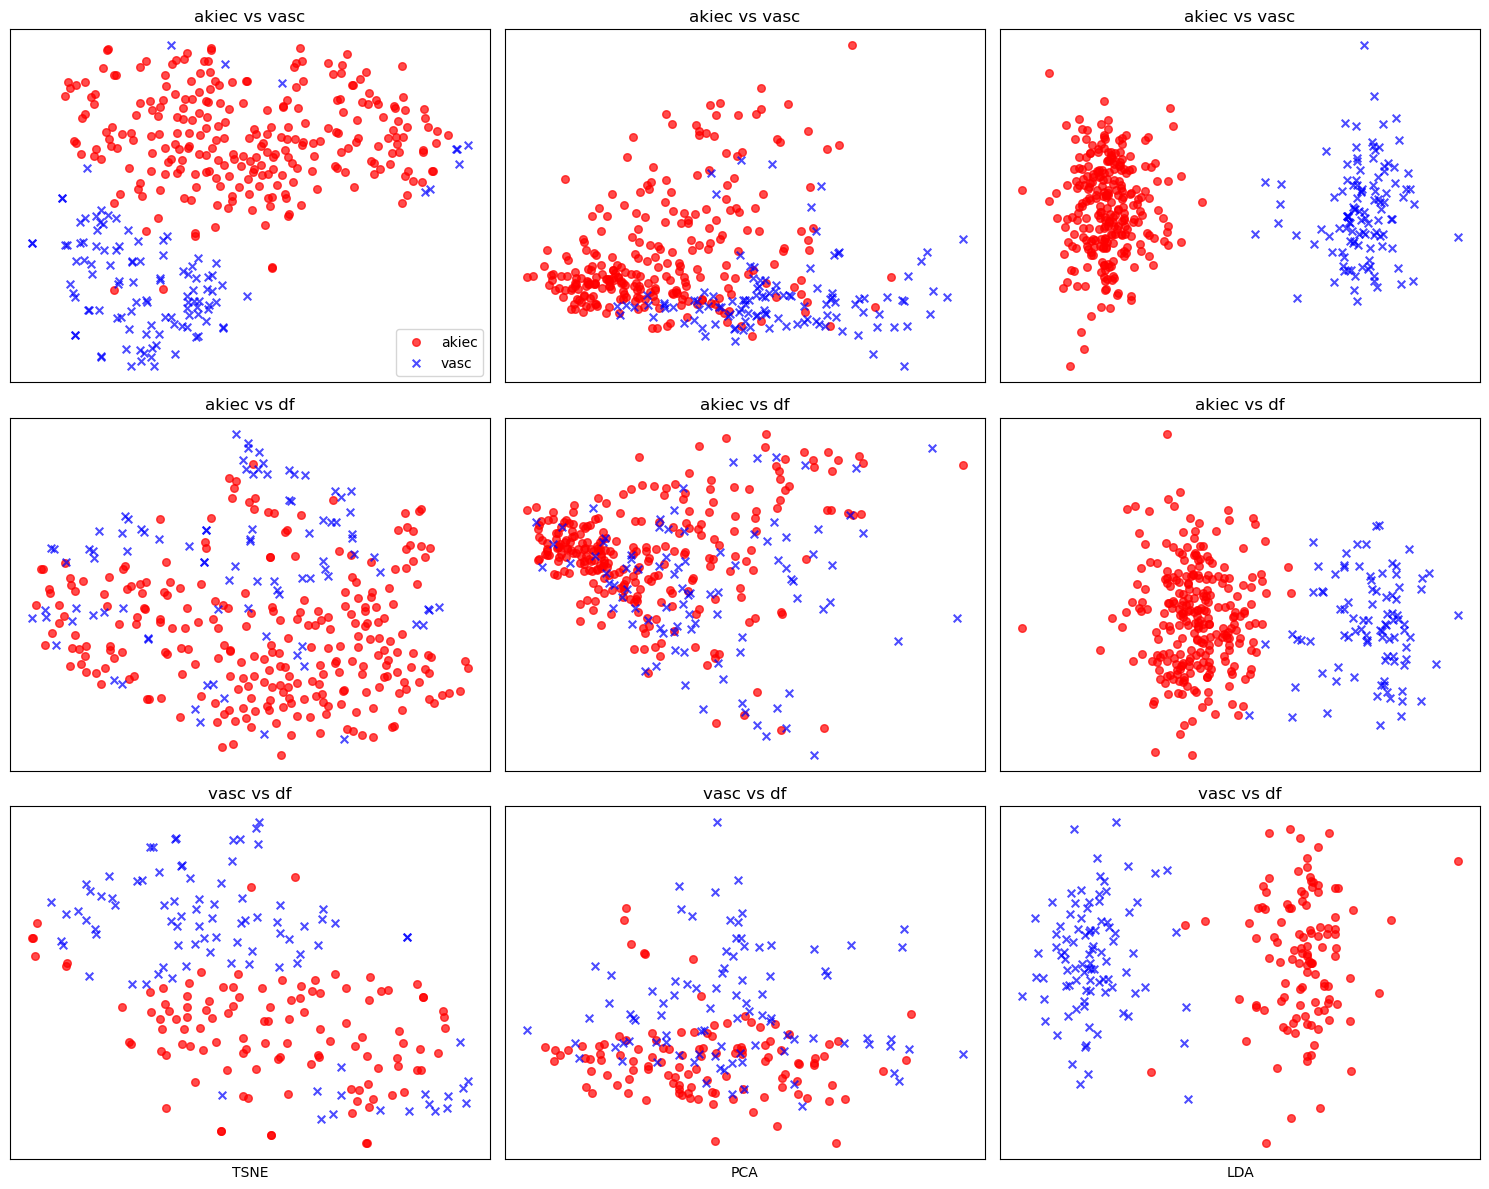

In [74]:
# Define pairs of classes to compare
class_pairs = [('akiec', 'vasc'), ('akiec', 'df'), ('vasc', 'df')]

# Create class comparison table
fig_class_comparison = create_class_comparison_table(
    train_features,
    train_labels,
    class_pairs,
    methods=['tsne', 'pca', 'lda'],
    figsize=(15, 12)
)

# Save the figure
fig_class_comparison.savefig('class_comparison_table.png', dpi=300, bbox_inches='tight')

### 9.2 Compare Real vs Synthetic Images Using LDA

Now, let's create visualizations comparing real vs synthetic images for each class (similar to Table V in the paper).

Processing class 1/3: akiec
Applying LDA to 561 samples...
Note: Added dummy dimension for visualisation since LDA only produced 1 component
Processing class 2/3: df
Applying LDA to 542 samples...
Note: Added dummy dimension for visualisation since LDA only produced 1 component
Processing class 3/3: vasc
Applying LDA to 563 samples...
Note: Added dummy dimension for visualisation since LDA only produced 1 component


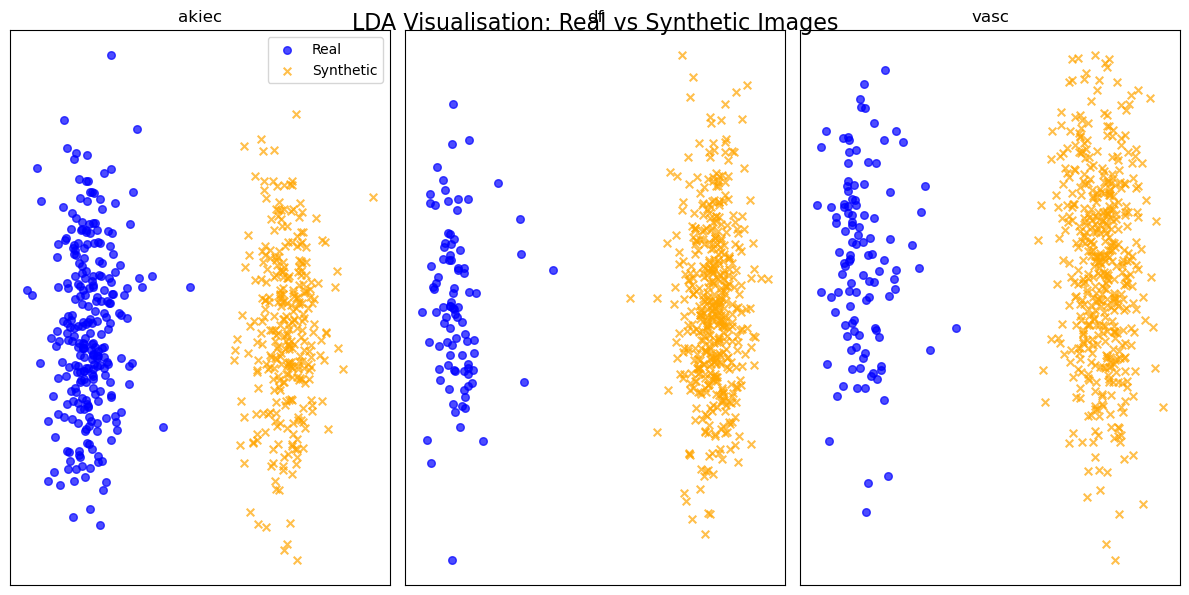

In [75]:
if synthetic_features is not None and synthetic_labels is not None:
    # Create real vs synthetic comparison table using LDA
    fig_real_synthetic = create_real_synthetic_comparison_table(
        train_features,
        train_labels,
        synthetic_features,
        synthetic_labels,
        classes=['akiec', 'df', 'vasc'],
        method='lda',
        figsize=(12, 6)
    )
    
    # Save the figure
    fig_real_synthetic.savefig('real_synthetic_comparison_lda.png', dpi=300, bbox_inches='tight')
else:
    print("Cannot create real vs synthetic comparison because synthetic data is not available.")

### 9.3 Individual Real vs Synthetic Comparisons for Each Class


Comparing akiec using LDA...
Comparing real vs synthetic for class akiec using LDA
Number of real samples: 261
Number of synthetic samples: 300
Using LDA to compare real vs synthetic (treating as 2 classes)


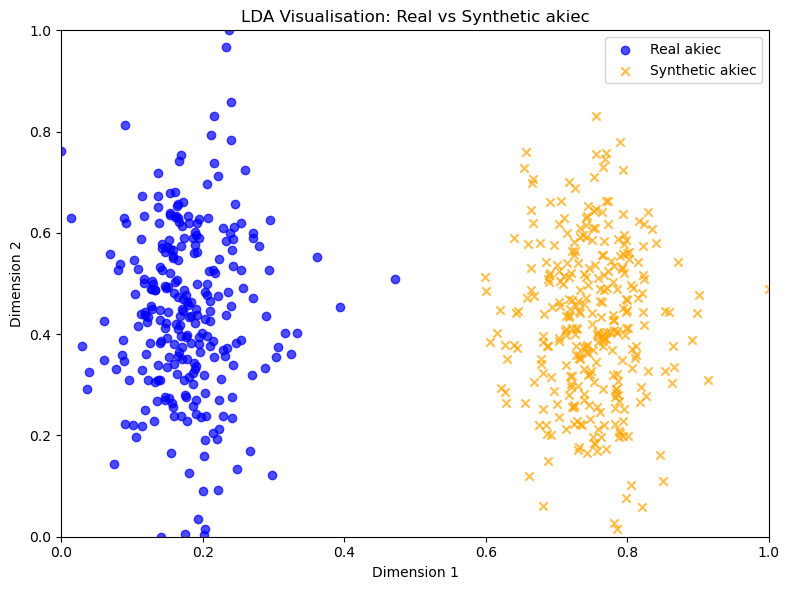


Comparing akiec using TSNE...
Comparing real vs synthetic for class akiec using TSNE
Number of real samples: 261
Number of synthetic samples: 300


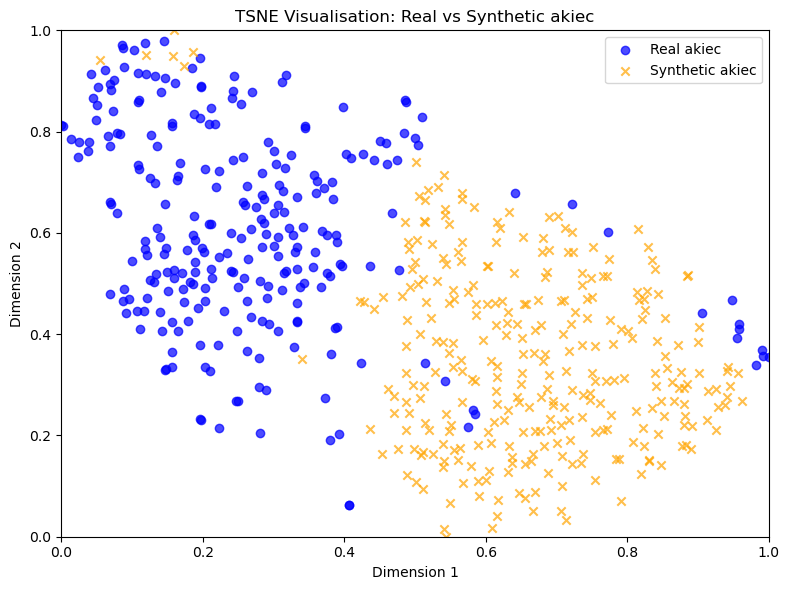


Comparing akiec using PCA...
Comparing real vs synthetic for class akiec using PCA
Number of real samples: 261
Number of synthetic samples: 300


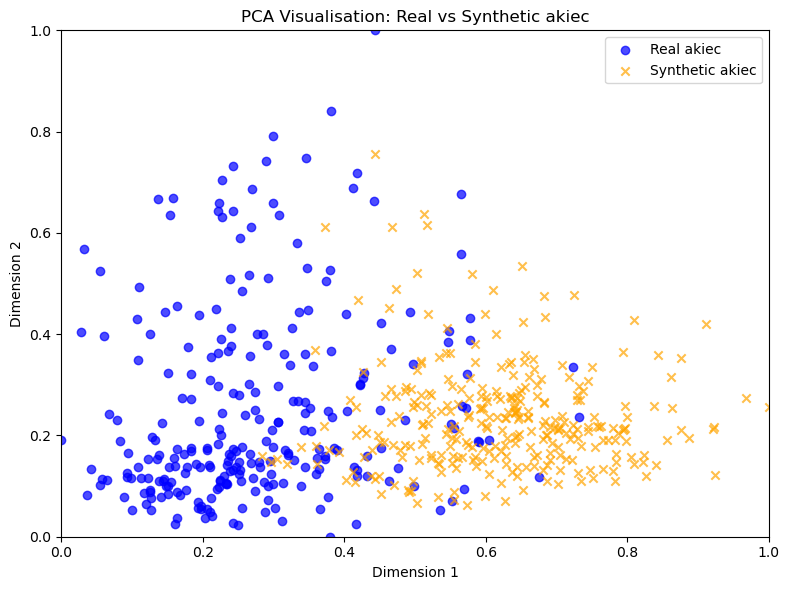


Comparing df using LDA...
Comparing real vs synthetic for class df using LDA
Number of real samples: 92
Number of synthetic samples: 450
Using LDA to compare real vs synthetic (treating as 2 classes)


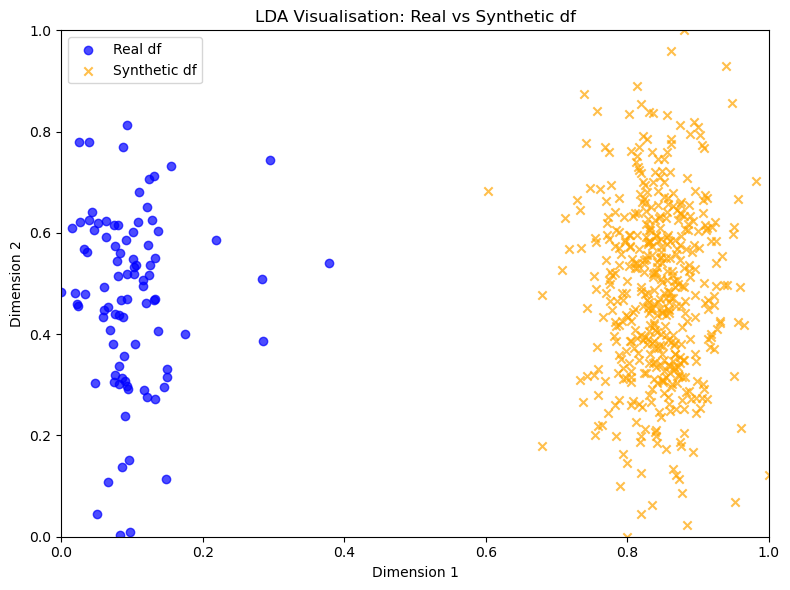


Comparing df using TSNE...
Comparing real vs synthetic for class df using TSNE
Number of real samples: 92
Number of synthetic samples: 450


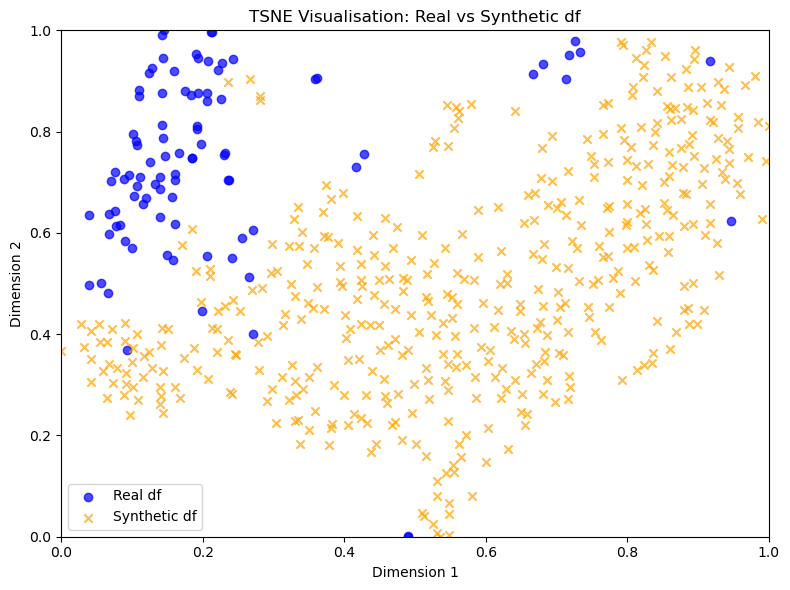


Comparing df using PCA...
Comparing real vs synthetic for class df using PCA
Number of real samples: 92
Number of synthetic samples: 450


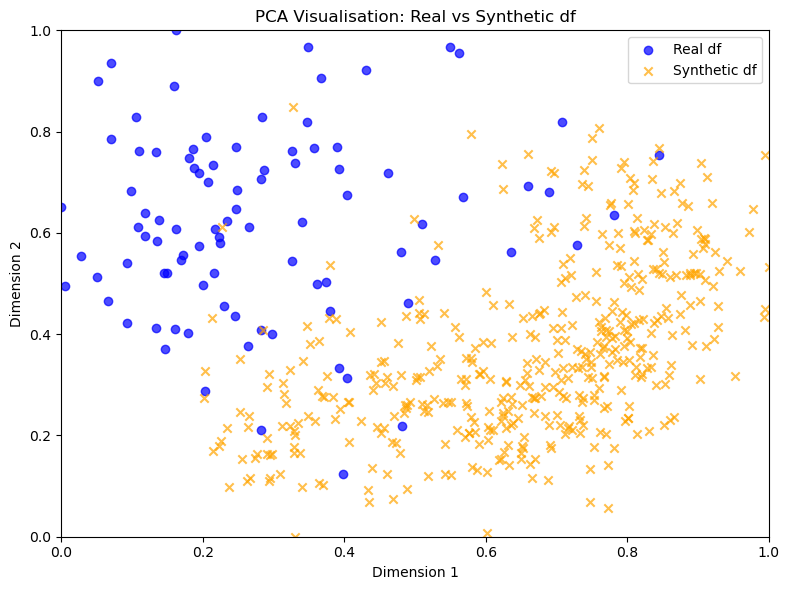


Comparing vasc using LDA...
Comparing real vs synthetic for class vasc using LDA
Number of real samples: 113
Number of synthetic samples: 450
Using LDA to compare real vs synthetic (treating as 2 classes)


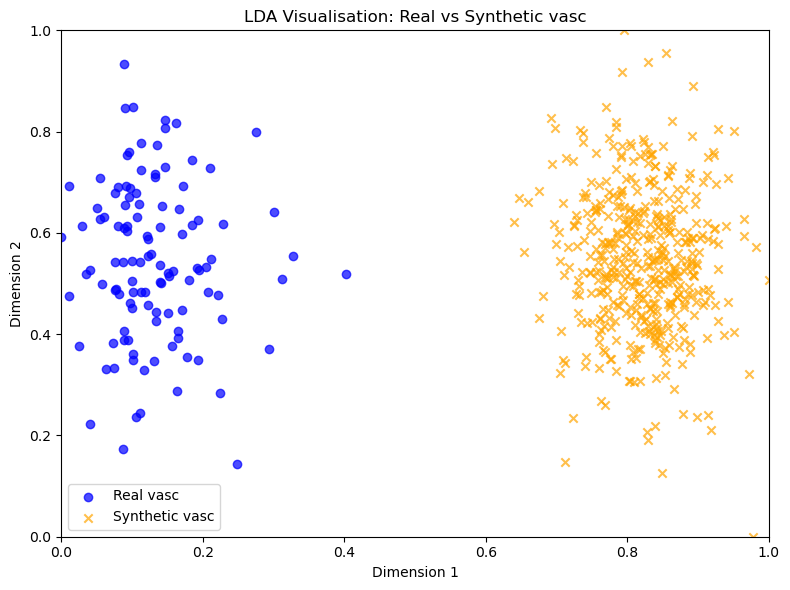


Comparing vasc using TSNE...
Comparing real vs synthetic for class vasc using TSNE
Number of real samples: 113
Number of synthetic samples: 450


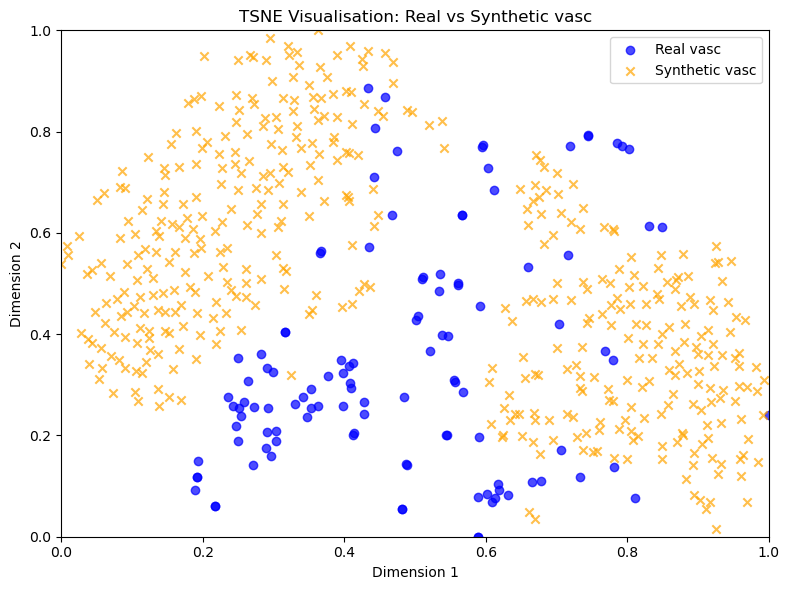


Comparing vasc using PCA...
Comparing real vs synthetic for class vasc using PCA
Number of real samples: 113
Number of synthetic samples: 450


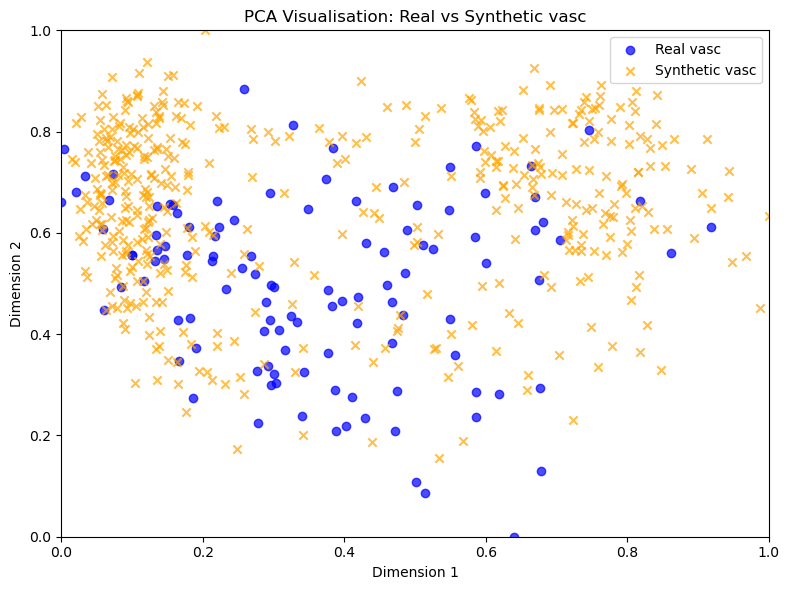

In [78]:
# Compare real vs synthetic for each class using multiple dimensionality reduction techniques
if synthetic_features is not None and synthetic_labels is not None:
    # Define methods to use for comparison
    methods = ['lda', 'tsne', 'pca']
    
    # For each class
    for class_name in ['akiec', 'df', 'vasc']:
        # For each dimensionality reduction method
        for method in methods:
            print(f"\nComparing {class_name} using {method.upper()}...")
            plot_real_vs_synthetic_comparison(
                train_features,
                train_labels,
                synthetic_features,
                synthetic_labels,
                method=method,
                class_name=class_name,
                figsize=(8, 6)
            )
else:
    print("Cannot create comparisons because synthetic data is not available.")

## 10. Conclusion and Findings

We've used dimensionality reduction techniques (t-SNE, PCA, and LDA) to visualize and compare real and synthetic skin lesion images from the HAM10000 dataset, focusing on the AKIEC, DF, and VASC classes.

### Key observations:

1. **Class Separation**: From the class comparison table, we can see how well different dimensionality reduction techniques separate the classes. LDA typically shows the best class separation as it's designed to maximize between-class variance while minimizing within-class variance.

2. **Real vs Synthetic Comparison**: The LDA plots comparing real and synthetic images help us understand how well the synthetic images capture the feature distribution of real images. Ideally, we want to see overlap between real and synthetic clusters, indicating that the generated images maintain key characteristics of the real data.

3. **Variation Within Classes**: The spread of points within each class cluster provides insight into the variation within that class. Tightly clustered points suggest less variation, while more dispersed points indicate greater diversity in appearance.

These visualizations can help assess the quality of synthetic images generated by the Stable Diffusion model and their potential utility for data augmentation in skin lesion classification tasks.